In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import random
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
from pathlib import Path
from PIL import Image
from typing import Optional, Union
import sys
import string
import time

In [2]:
import torch
from torch import nn, Tensor
from torch.nn import functional as Function
from torch.utils import data
from torchvision import utils
from torchvision import datasets, transforms
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
print(torch.cuda.memory_summary(device=torch.cuda.current_device()))
print("Allocated Memory: ", torch.cuda.memory_allocated()/1e6, "MB")
print("Cahced Memory: ", torch.cuda.memory_reserved()/1e6, "MB")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [4]:
from hyperparameters import *

In [5]:
image_dataset_folder = IMAGE_DATASET_FOLDER
train_path_original = TRAIN_PATH_ORIGINAL
test_path_original = TEST_PATH_ORIGINAL
dataset_batch_size = DATASET_BATCH_SIZE

In [6]:
# Set Seed just to ensure that results are Valid
random_seed = RANDOM_SEED
# random.seed(random_seed)
# np.random.seed(random_seed)
# torch.manual_seed(random_seed)
# torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed)
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [7]:
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
# print(f'Using current CUBLAS environment = {os.environ.get("CUBLAS_WORKSPACE_CONFIG")}')

In [8]:
alphabets = list(string.ascii_uppercase)
idx_to_class = {i : alphabet for i, alphabet in enumerate(alphabets)}
num_classes = len(alphabets)
str([num_classes, idx_to_class])

"[26, {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}]"

In [9]:
transform_metrics_training = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.25, interpolation=3),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
training = datasets.ImageFolder(image_dataset_folder+train_path_original, transform=transform_metrics_training)
testing = datasets.ImageFolder(image_dataset_folder+test_path_original, transform=val_test_transform)

In [11]:
print("Total Number of Training Data samples:", len(training))
print("Total Number of Testing Data samples:", len(testing))
dataset_training_size = int(0.8*TOTAL_DATASET_SIZE)
dataset_testing_size = int(TOTAL_DATASET_SIZE-dataset_training_size)
training_size = int(0.8 * dataset_training_size)
validation_size  = int(dataset_training_size - training_size)
print(f'Total Size of Dataset       : {TOTAL_DATASET_SIZE}')
print(f'Size of Training Dataset    : {dataset_training_size}')
print(f'Size of Testing Dataset     : {dataset_testing_size}')
print(f'Size of Training Dataset    : {training_size}')
print(f'Size of Validation Dataset  : {validation_size}')
train_dataset, _ = torch.utils.data.random_split(training, [training_size, len(training)-training_size])
validation_dataset, test_dataset = torch.utils.data.random_split(testing, [validation_size, len(testing)-validation_size])
test_dataset, _ = torch.utils.data.random_split(test_dataset, [dataset_testing_size, len(test_dataset)-dataset_testing_size])
train_loader_aug = DataLoader(train_dataset, batch_size=dataset_batch_size, shuffle=True)
val_loader_aug = DataLoader(validation_dataset, batch_size=dataset_batch_size, shuffle=False)
test_loader_aug = DataLoader(test_dataset, batch_size=dataset_batch_size, shuffle=False)

Total Number of Training Data samples: 50000
Total Number of Testing Data samples: 10000
Total Size of Dataset       : 20000
Size of Training Dataset    : 16000
Size of Testing Dataset     : 4000
Size of Training Dataset    : 12800
Size of Validation Dataset  : 3200


In [12]:
images, labels = next(iter(train_loader_aug))
print(f'{images.size()} | {labels.size()}')

torch.Size([32, 3, 224, 224]) | torch.Size([32])


In [13]:
print("Detected Classes are: ", datasets.ImageFolder(image_dataset_folder+train_path_original, transform=transform_metrics_training).class_to_idx) 
num_classes = len(datasets.ImageFolder(image_dataset_folder+train_path_original, transform=transform_metrics_training).class_to_idx)

def ensure_loader_works(loader:string) -> None:
    images, labels = next(iter(train_loader_aug))
    print(f'{loader} should work as intended')

ensure_loader_works(train_loader_aug)
ensure_loader_works(val_loader_aug)
ensure_loader_works(test_loader_aug)
print(f'Total number of classes is: {num_classes}')
print(f"Size of Training Data Loader: {len(train_loader_aug)*dataset_batch_size} ")
print(f"Size of Validation Data Loader: {len(val_loader_aug)*dataset_batch_size} ")
print(f"Size of Testing Data Loader: {len(test_loader_aug)*dataset_batch_size} ")

Detected Classes are:  {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
<torch.utils.data.dataloader.DataLoader object at 0x745ea2311490> should work as intended
<torch.utils.data.dataloader.DataLoader object at 0x745f0d1773a0> should work as intended
<torch.utils.data.dataloader.DataLoader object at 0x745f0d177a00> should work as intended
Total number of classes is: 10
Size of Training Data Loader: 12800 
Size of Validation Data Loader: 3200 
Size of Testing Data Loader: 4000 


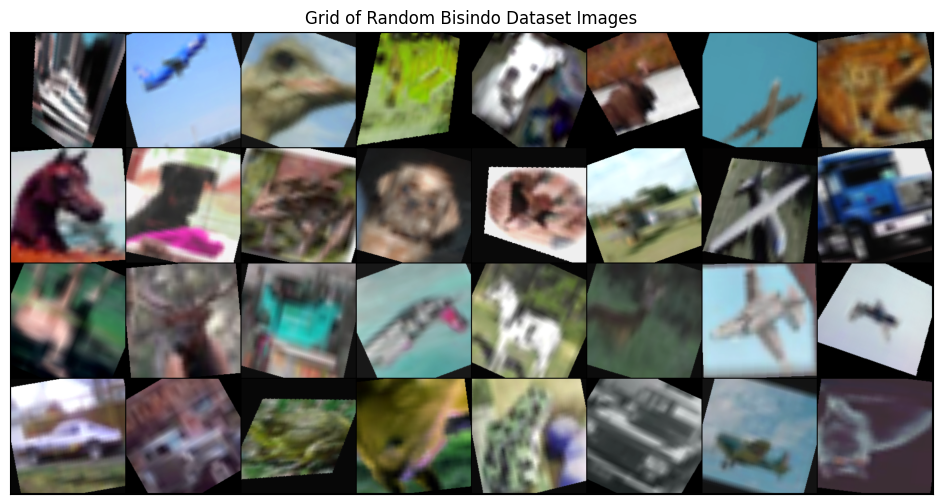

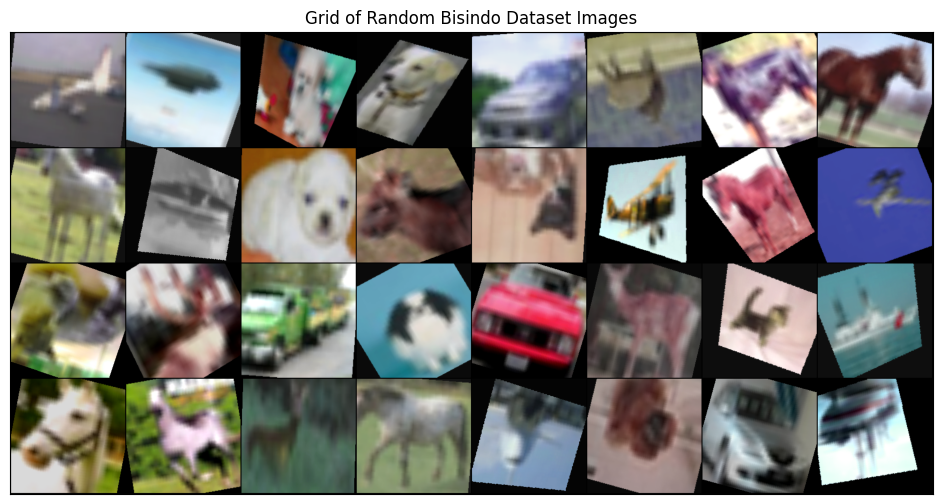

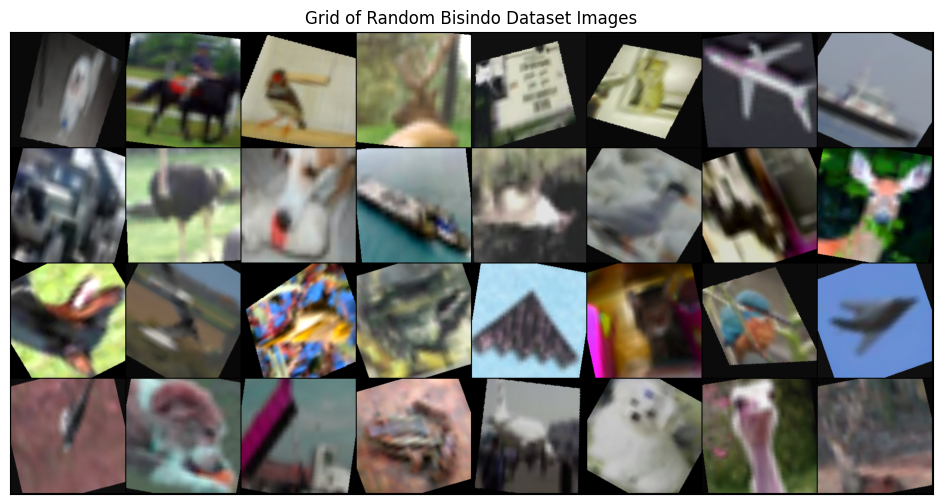

In [14]:
import matplotlib.pyplot as plt
import torchvision.utils as utils

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(img_tensor, mean, std):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization
    return img_tensor

def plot_random_grid_images()->None:
    images, labels = next(iter(train_loader_aug))
    images_denorm = torch.stack([denormalize(img.clone(), mean, std) for img in images])
    grid_tensor = utils.make_grid(images_denorm, nrow=8).permute(1, 2, 0)  # Change to HWC for plt.imshow
    plt.figure(figsize=(12, 6))  # Adjust size as needed
    plt.imshow(grid_tensor.numpy())
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Remove ticks
    plt.title("Grid of Random Bisindo Dataset Images")
    plt.show()

plot_random_grid_images()
plot_random_grid_images()
plot_random_grid_images()

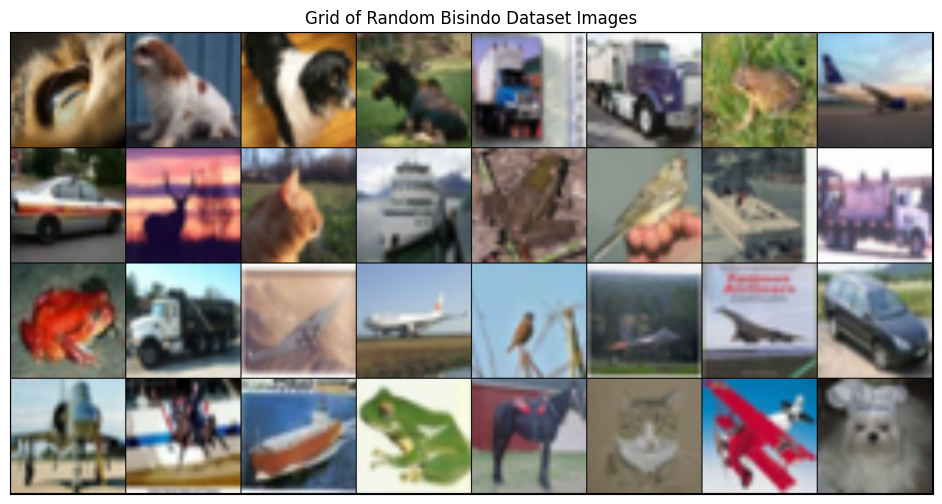

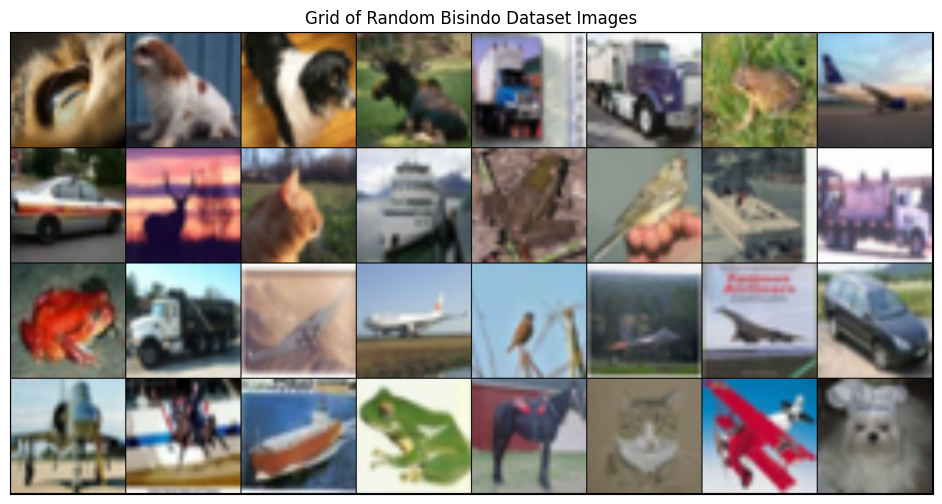

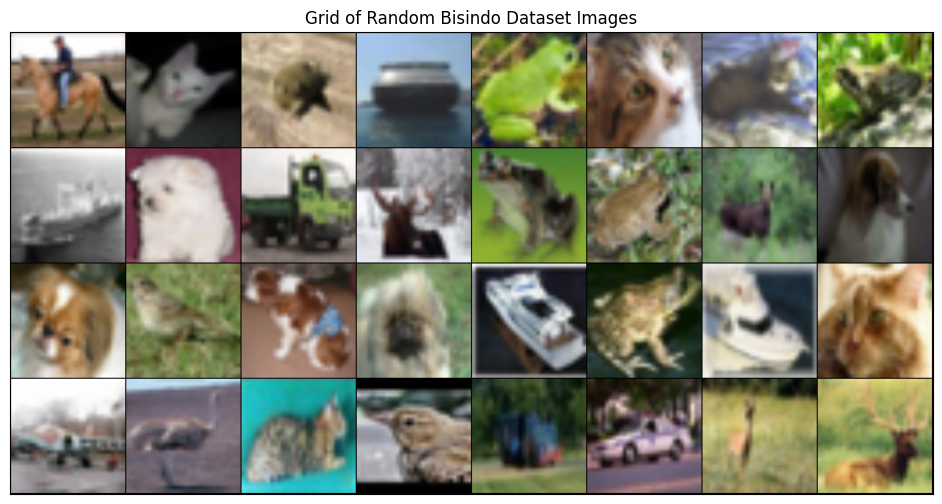

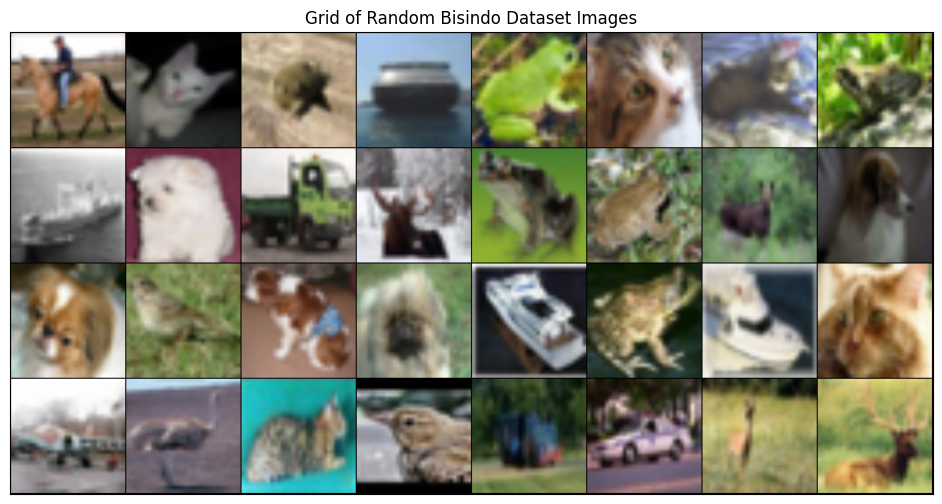

In [15]:
def plot_random_grid_images_validation(dataset:string)->None:
    images, labels = next(iter(dataset))
    images_denorm = torch.stack([denormalize(img.clone(), mean, std) for img in images])
    grid_tensor = utils.make_grid(images_denorm, nrow=8).permute(1, 2, 0)  # Change to HWC for plt.imshow
    plt.figure(figsize=(12, 6))  # Adjust size as needed
    plt.imshow(grid_tensor.numpy())
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Remove ticks
    plt.title("Grid of Random Bisindo Dataset Images")
    plt.show()

plot_random_grid_images_validation(val_loader_aug)
plot_random_grid_images_validation(val_loader_aug)
plot_random_grid_images_validation(test_loader_aug)
plot_random_grid_images_validation(test_loader_aug)

# **Define the Model Parameters**

To train this model, we will train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5:

# **Initialized Model and Feature Extractor**

In [16]:
huggingface_model_name = 'WinKawaks/vit-tiny-patch16-224'

In [17]:
import transformers
from transformers import ViTModel, SwinModel, CvtModel
from transformers import ViTFeatureExtractor, SwinForImageClassification, CvtForImageClassification
from transformers.modeling_outputs import ImageClassifierOutput

class ViTForImageClassification(nn.Module):
    def __init__(self, num_classes:int, model_name:string, dropout = DROPOUT) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.model = ViTModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(self.model.config.hidden_size ,num_classes)
    
    def forward(self, pixel_values: Optional[torch.Tensor] = None, labels: Optional[torch.Tensor] = None, 
                return_dict: Optional[bool] = None) -> Union[tuple, ImageClassifierOutput]:
        return_dict = return_dict if return_dict is not None else True
        outputs = self.model(pixel_values=pixel_values)
        sequence_output = self.dropout(outputs.last_hidden_state[:, 0, :])
        logits = self.classifier(sequence_output)
        loss = None

        if labels is not None:
          loss_function = nn.CrossEntropyLoss()
          loss = loss_function(logits.view(-1, self.num_classes), labels.view(-1))

        if not return_dict:
          if loss is not None:
             output = (logits,) + outputs[1:]
             return ((loss,) + output)
          else:
            output = (logits,) + outputs[1:]
            return output
        
        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,)

/home/web-scientia/miniconda3/envs/devan_ths/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
print(f'Using pretrained model: {huggingface_model_name}')
model = ViTForImageClassification(num_classes,huggingface_model_name)
feature_extractor = ViTFeatureExtractor.from_pretrained(huggingface_model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss().to(device)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = EPOCHS*len(train_loader_aug))
model.to(device)

Using pretrained model: WinKawaks/vit-tiny-patch16-224


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/web-scientia/miniconda3/envs/devan_ths/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTForImageClassification(
  (model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_

In [19]:
print(torch.cuda.memory_summary(device=torch.cuda.current_device()))
print("Allocated Memory: ", torch.cuda.memory_allocated()/1e6, "MB")
print("Cahced Memory: ", torch.cuda.memory_reserved()/1e6, "MB")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  21761 KiB |  21761 KiB |  21761 KiB |      0 B   |
|       from large pool |      0 KiB |      0 KiB |      0 KiB |      0 B   |
|       from small pool |  21761 KiB |  21761 KiB |  21761 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |  21761 KiB |  21761 KiB |  21761 KiB |      0 B   |
|       from large pool |      0 KiB |      0 KiB |      0 KiB |

In [20]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Number of Parameters present in Model: {pytorch_total_params}')

Number of Parameters present in Model: 5563402


In [21]:
# del(model)

# **Train the Model**

In [22]:
class averageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, pred = outputs.topk(1, dim=1, largest=True, sorted=True)
    pred = pred.t() 
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [23]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  Loss_Training = train_loss_avg
  Loss_Value = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, Loss_Training, 'g', label='Training loss')
  plt.plot(epochs, Loss_Value, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  Loss_Training = train_accuracy
  Loss_Value = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, Loss_Training, 'g', label='Training accuracy')
  plt.plot(epochs, Loss_Value, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [24]:
losses_training = []
losses_validation = []
accuracy_traning = []
accuracy_validation = []

In [25]:
start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    current_average_loss_training = averageMeter()
    current_average_accuracy_training = averageMeter()

    for i, (inputs, labels) in enumerate(train_loader_aug):
        if torch.cuda.is_available(): inputs, labels = inputs.to(device), labels.to(device).type(torch.cuda.LongTensor)
        else: inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        current_epoch_accuracy = calculate_accuracy(outputs.logits, labels)
        current_average_loss_training.update(loss.item(), inputs.size(0))
        current_average_accuracy_training.update(current_epoch_accuracy, inputs.size(0))
        model.eval()
        model.train()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
            % (
                epoch,
                EPOCHS,
                i,
                len(train_loader_aug),
                current_average_loss_training.avg,
                current_average_accuracy_training.avg)
        )
    print(" ")
    torch.save(model.state_dict(),'checkpoint.pt')
    losses_training.append(current_average_loss_training.avg)
    accuracy_traning.append(current_average_accuracy_training.avg)

    model.eval()
    avarage_loss_validation = averageMeter()
    avarage_accuracy_validation = averageMeter()
    prediction = []
    ground_truth = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader_aug):
            if torch.cuda.is_available(): inputs, labels = inputs.to(device), labels.to(device).type(torch.cuda.LongTensor)
            else: inputs.to(device), labels.to(device)
            outputs = model(inputs)
            validation_losses = torch.mean(criterion(outputs.logits, labels))
            validation_accuracy = calculate_accuracy(outputs.logits, labels)
            _, predicted = torch.max(outputs.logits, 1)

            ground_truth += labels.detach().cpu().numpy().reshape(len(labels)).tolist()
            prediction += predicted.detach().cpu().numpy().reshape(len(predicted)).tolist()
            avarage_loss_validation.update(validation_losses.item(), inputs.size(0))
            avarage_accuracy_validation.update(validation_accuracy, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(val_loader_aug),
                        avarage_loss_validation.avg,
                        avarage_accuracy_validation.avg
                    )
            )
        print(" ")
    losses_validation.append(avarage_loss_validation.avg)
    accuracy_validation.append(avarage_accuracy_validation.avg)
end_time = time.time()
total_time_seconds = end_time - start_time
hours = total_time_seconds // 3600
minutes = (total_time_seconds % 3600) // 60
seconds = total_time_seconds % 60
print(f'Total training time for current model took around {int(hours)}h {int(minutes)}m {seconds:.2f}s')

[Epoch 0/10] [Batch 399 / 400] [Loss: 1.813304, Acc: 37.08%] 
[Batch 99 / 100]  [Loss: 1.171734, Acc: 61.03%] 
[Epoch 1/10] [Batch 399 / 400] [Loss: 0.980748, Acc: 65.77%] 
[Batch 99 / 100]  [Loss: 0.533048, Acc: 82.09%] 
[Epoch 2/10] [Batch 259 / 400] [Loss: 0.728239, Acc: 74.72%]

KeyboardInterrupt: 

In [26]:
sorted_accuracy_traning = sorted(accuracy_traning)
sorted_losses_training = sorted(losses_training)
sorted_accuracy_validation = sorted(accuracy_validation)
sorted_losses_validation = sorted(losses_validation)
print(f"=========================================================================")
print(f"Total Training Accuracy: {sum(accuracy_traning)/len(accuracy_traning)}%")
print(f"Total Training Loss: {sum(losses_training)/len(losses_training)}%")
print(f"=========================================================================")
print(f"Best Training Accuracy: {sorted_accuracy_traning[-1]:.2f}%")
print(f"Best Training Loss: {sorted_losses_training[0]:.2f}%") 
print(f"=========================================================================")
print(f"Total Validation Accuracy: {sum(accuracy_validation)/len(accuracy_validation)}%")
print(f"Total Validation Loss: {sum(losses_validation)/len(losses_validation)}%")
print(f"=========================================================================")
print(f"Best Validation Accuracy: {sorted_accuracy_validation[-1]:.2f}%")
print(f"Best Validation Loss: {sorted_losses_validation[0]:.2f}%") 
print(f"=========================================================================")

Total Training Accuracy: 51.42578125%
Total Training Loss: 1.3970263046771287%
Best Training Accuracy: 65.77%
Best Training Loss: 0.98%
Total Validation Accuracy: 71.5625%
Total Validation Loss: 0.8523910719156266%
Best Validation Accuracy: 82.09%
Best Validation Loss: 0.53%


2


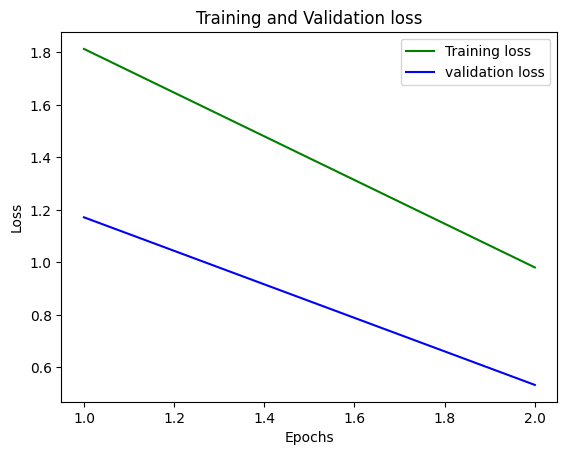

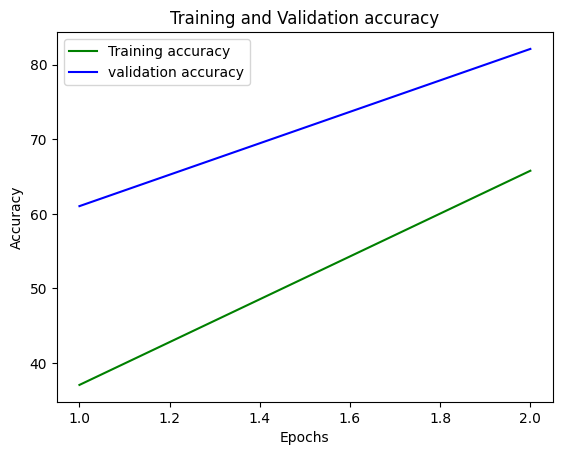

[[286   2   3   1   0   0   0   1  23   5]
 [  1 306   0   0   0   0   0   0   1  10]
 [ 10   1 267   9  23   7  10   7   6   1]
 [  3   2  13 221  27  41  10   9   8   3]
 [  3   0  10   4 226   9   2  40   6   0]
 [  1   0   7  26  10 236   2  13   4   3]
 [  6   3  36  36  20   4 200   2   3   1]
 [  4   0   2   9   6   9   1 288   3   3]
 [ 12   4   0   0   0   0   0   0 307   0]
 [  6  19   0   0   0   0   0   1   6 290]]


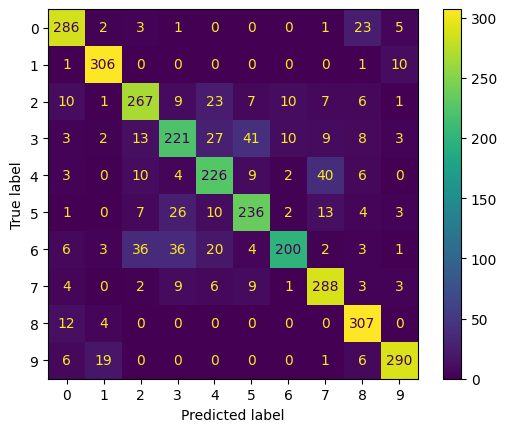

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
plot_loss(losses_training,losses_validation,len(losses_training))
plot_accuracy(accuracy_traning,accuracy_validation,len(accuracy_traning))
cm = confusion_matrix(ground_truth,prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print(cm)
disp.plot()
plt.show()

In [28]:
classification_report_table = classification_report(ground_truth, prediction, output_dict=True)
classification_report_dataframe = pd.DataFrame(classification_report_table).transpose()
classification_report_dataframe

precision    recall  f1-score      support
0              0.861446  0.890966  0.875957   321.000000
1              0.908012  0.962264  0.934351   318.000000
2              0.789941  0.782991  0.786451   341.000000
3              0.722222  0.655786  0.687403   337.000000
4              0.724359  0.753333  0.738562   300.000000
5              0.771242  0.781457  0.776316   302.000000
6              0.888889  0.643087  0.746269   311.000000
7              0.797784  0.886154  0.839650   325.000000
8              0.836512  0.950464  0.889855   323.000000
9              0.917722  0.900621  0.909091   322.000000
accuracy       0.820937  0.820937  0.820937     0.820937
macro avg      0.821813  0.820712  0.818390  3200.000000
weighted avg   0.821774  0.820937  0.818526  3200.000000

In [ ]:
# torch.save(model.state_dict(), 'models/vit-tiny-pytorch.pth')

In [29]:
model.eval()
avarage_accuracy_testing = averageMeter()
prediction = []
ground_truth = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader_aug):
        if torch.cuda.is_available(): inputs, labels = inputs.to(device), labels.to(device).type(torch.cuda.LongTensor)
        else: inputs.to(device), labels.to(device)
        outputs = model(inputs)
        testing_accuracy = calculate_accuracy(outputs.logits, labels)
        _, predicted = torch.max(outputs.logits, 1)
        ground_truth += labels.detach().cpu().numpy().reshape(len(labels)).tolist()
        prediction += predicted.detach().cpu().numpy().reshape(len(predicted)).tolist()
        avarage_accuracy_testing.update(testing_accuracy, inputs.size(0))
    print(f"Total Testing Accuracy: {avarage_accuracy_testing.avg}%")

Total Testing Accuracy: 86.625%


In [ ]:
cm = confusion_matrix(ground_truth,prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print(cm)
disp.plot()
plt.show()

In [ ]:
classification_report_table = classification_report(ground_truth, prediction, output_dict=True)
classification_report_dataframe = pd.DataFrame(classification_report_table).transpose()
classification_report_dataframe